# Credit Card Approval Prediction using ML

Credit card approval is a critical decision-making process for financial institutions that involves assessing the creditworthiness of applicants to minimize default risk while maximizing customer acquisition. Traditionally, this process has relied on manual review of applications, which can be time-consuming, subjective, and prone to human error. With the advent of machine learning and data analytics, financial institutions can now leverage historical data to build predictive models that automate and enhance the credit card approval process. This project aims to develop a robust machine learning model that predicts whether a credit card application should be approved or rejected based on various applicant characteristics. 

## About the Data

The credit card application data is obtained from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/27/credit+approval), which was anonymized for confidentiality. This dataset contains 690 rows with mixed attributes and missing values. There are 15 features (A1 to A15) and one target variable (A16) in the dataset as shown from the website:

![Features](data/Variables_Name.png)



## Step 1. Load Packages and Data
I'll start by loading the necessary Python packages along with the data.

In [1]:
# math and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score

# filter out warnings
import warnings
warnings.filterwarnings('ignore')

# set seaborn style
sns.set_style('whitegrid')

# render Matplotlib figures
%matplotlib inline

In [2]:
# read in data while adding column names
header_names = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16']
df = pd.read_csv('./data/crx.data',names=header_names)

## Step 2. Exploratory Data Analysis

Next, I'll perform Exploratory Data Analysis (EDA) to obtain a deeper understanding of the data. EDA is essential for identifying patterns, outliers, correlations, and potential data quality issues. My EDA will focus on the following:

- Review basic summary statistics to understand the central tendency and scale of numerical variables
- Check for missing values, invalid entries, or duplicate samples
- Search for high-cardinality categorical features
- Visualize feature distributions to help identify skewed distributions or outliers
- Inspect the target variable's distribution to identify any class imbalance
- Visualize feature distributions by the target variable

### Step 2.1. Basic Summary Statistics
I'll use `panda`'s `df.head()` to see the first 5 rows of the data, `df.info()` to see a high-level summary of each column, and `df.describe()` to review a summary of basic statistics of the numeric variables.

In [3]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    object 
 1   A2      690 non-null    object 
 2   A3      690 non-null    float64
 3   A4      690 non-null    object 
 4   A5      690 non-null    object 
 5   A6      690 non-null    object 
 6   A7      690 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-null    object 
 9   A10     690 non-null    object 
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    object 
 13  A14     690 non-null    object 
 14  A15     690 non-null    int64  
 15  A16     690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [6]:
df.describe()

,A3,A8,A11,A15
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


There are a total of 690 data samples with 2 float, 2 integer, and 12 object columns. Several object columns appear to contain float values (`A2`, `A14`), so there may be invalid entries in these columns preventing these features from being entirely numeric. While three of the numeric columns have similar central tendencies and distribution widths, the `A15` column has a range of values that are several orders of magnitude larger than the rest. Feature scaling will therefore be needed to normalize the numerical columns to a consistent distribution, particularly for the logistic regression and KNN models.

### Step 2.2. Check for Missing Values, Invalid Entries, or Duplicates
Next I'll look for missing values, invalid entries, and duplicate samples. I'll start by verifying that there are no `null` entries using `panda`'s `df.isnull()` function.

In [7]:
# look for null entries
df.isna().sum().to_frame().T

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


While there are no `null` entries, I like to search the object columns for placeholders such as `?` and `...` that might represent missing data.

In [58]:
# define placeholder entries to search for
placeholders = ['?', '.', 'na', 'n/a', 'none']

for col in df.select_dtypes(include='object'):
    mask = df[col].isin(placeholders)
    if mask.any():
        print(f"{col}:\n {df[mask][col]}\n\n")
    else:
        print(f"{col}: No placeholder entries.")

A1:
 248    ?
327    ?
346    ?
374    ?
453    ?
479    ?
489    ?
520    ?
598    ?
601    ?
641    ?
673    ?
Name: A1, dtype: object


A2:
 83     ?
86     ?
92     ?
97     ?
254    ?
286    ?
329    ?
445    ?
450    ?
500    ?
515    ?
608    ?
Name: A2, dtype: object


A4:
 206    ?
270    ?
330    ?
456    ?
592    ?
622    ?
Name: A4, dtype: object


A5:
 206    ?
270    ?
330    ?
456    ?
592    ?
622    ?
Name: A5, dtype: object


A6:
 206    ?
270    ?
330    ?
456    ?
479    ?
539    ?
592    ?
601    ?
622    ?
Name: A6, dtype: object


A7:
 206    ?
270    ?
330    ?
456    ?
479    ?
539    ?
592    ?
601    ?
622    ?
Name: A7, dtype: object


A9: No placeholder entries.
A10: No placeholder entries.
A12: No placeholder entries.
A13: No placeholder entries.
A14:
 71     ?
202    ?
206    ?
243    ?
270    ?
278    ?
330    ?
406    ?
445    ?
456    ?
592    ?
622    ?
626    ?
Name: A14, dtype: object


A16: No placeholder entries.


It looks like there are a number of missing entries with the placeholder `?` so let's replace these with the more common convention of `NaN` using `panda`'s `df.replace()` and inspect their distribution.

In [59]:
# replace '?' placeholders with NaNs
df.replace('?',np.nan,inplace=True)

In [8]:
# review distribution of NaNs across features
df.isna().sum().to_frame().T

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The missing entries account for less than 2% of the dataset, so I will simply remove the corresponding samples using `panda`'s `df.dropna()`. If removing these entries was not an ideal solution, I could imputate them with the last valid entry using `panda`s `df.ffill()`.

In [61]:
# drop NaNs
df = df.dropna()

Let's verify that the rows with missing entries were successfully removed.

In [9]:
# review distribution of NaNs across features
df.isna().sum().to_frame().T

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


With the missing entries removed, I will now look for duplicate samples using `panda`'s `df.duplicated()`.

In [63]:
# look for duplicate entries
df.duplicated().sum()

np.int64(0)

There are no duplicate entries. Now that there are no `?` placeholders for missing entries, I will try converting the three object columns `A2`, `A3`, and `A14` to floats.

In [64]:
df['A2'] = df.A2.astype(float)
df['A3'] = df.A3.astype(float)
df['A14'] = df.A14.astype(float)

I will now convert the two integer features A11 and A15 to floats.

In [65]:
df['A11'] = df.A11.astype(float)
df['A15'] = df.A15.astype(float)

Having converted three object to numeric features, I will review the summary statistics of the numeric features one final time.

In [66]:
df.describe()

,A2,A3,A8,A11,A14,A15
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,31.503813,4.829533,2.244296,2.502297,180.359877,1013.761103
std,11.838267,5.027077,3.371120,4.968497,168.296811,5253.278504
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.580000,1.040000,0.165000,0.000000,73.000000,0.000000
50%,28.420000,2.835000,1.000000,0.000000,160.000000,5.000000
75%,38.250000,7.500000,2.625000,3.000000,272.000000,400.000000
max,76.750000,28.000000,28.500000,67.000000,2000.000000,100000.000000


While `A2` and `A3` appear similar in nature to the other numeric features, the values in `A14` are orders of magnitude larger than the rest, just like we saw with `A15`. This reinforces the need for feature scaling.

### Step 2.3. Search for High-Cardinality Categorical Features
Next, I'll search for categorical features with high cardinality using `panda`'s `df.select_dtypes()`.

In [67]:
print("Number of unique labels per categorical feature:\n")
for col in df.select_dtypes(include='object'):
    print(f"{col}: {df[col].nunique()}")

Number of unique labels per categorical feature:

A1: 2
A4: 3
A5: 3
A6: 14
A7: 9
A9: 2
A10: 2
A12: 2
A13: 3
A16: 2


The categorical feature with the highest cardinality has a number of unique labels that corresponds to only 2% of the number of data samples. Since this is quite low, none of the categorical features are considered high cardinality.

### Step 2.4. Feature Distributions

#### Step 2.4.1. Visualize Categorical Feature Distribution

In [68]:
# define a function to generate feature distribution

def plot_categorical_distributions(df, columns):
    for i in range(0, len(columns), 3):
        batch = columns[i:i+3]
        fig, axes = plt.subplots(1, len(batch), figsize=(14, 4))
        
        if len(batch) == 1:
            axes = [axes]  # Convert to list if only one axis
            
        for j, col in enumerate(batch):
            sns.countplot(data=df, x=col, hue="A16", ax=axes[j], 
                         palette={'+': 'skyblue', '-': 'salmon'})
            axes[j].set_title(f'Distribution of {col}')
            axes[j].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()


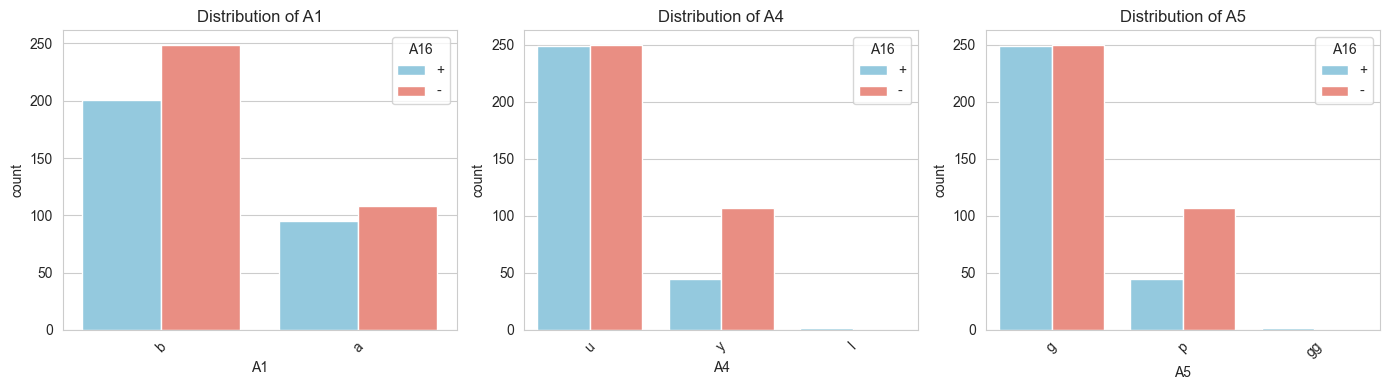

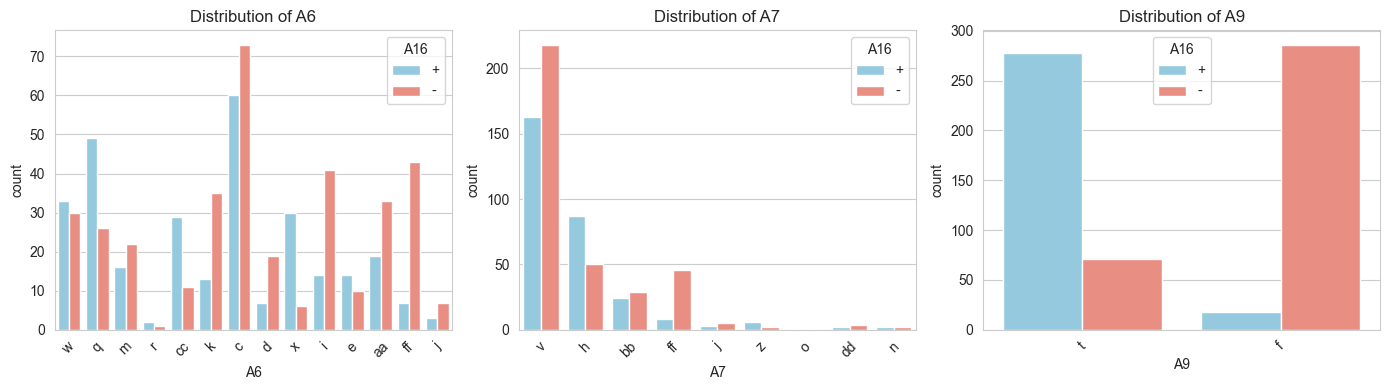

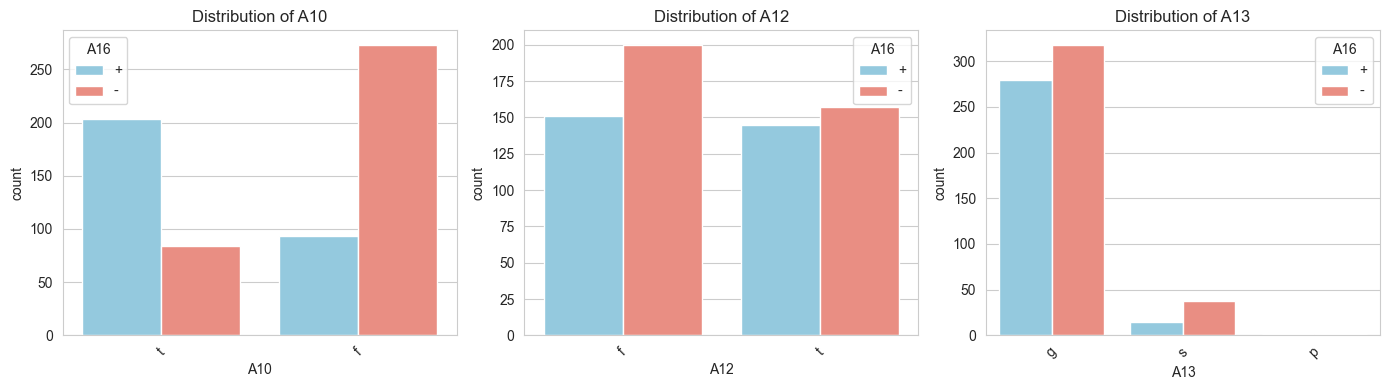

In [69]:
# Getting List of categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col !='A16']

# Plot categorical distributions per target group (+ or minus)
plot_categorical_distributions(df, columns=categorical_cols)

In each stratification of A9 (t, f), a clear contrast is observed between the two target classes (+ and −), indicating the potential predictive power of the A9 feature.

#### Step 2.4.2. Visualize Continuous Feature Distribution

In [70]:
def plot_numerical_distributions(df, columns):
    for i in range(0, len(columns), 3):
        batch = columns[i:i+3]
        fig, axes = plt.subplots(1, len(batch), figsize=(14, 4))
        
        if len(batch) == 1:
            axes = [axes]  # Convert to list if only one axis
            
        for j, col in enumerate(batch):
            sns.histplot(df, x=col, hue="A16", kde=True, ax=axes[j], bins=20, 
                        palette={'+': 'skyblue', '-': 'salmon'})
            axes[j].set_title(f'Distribution of {col}')
        
        plt.tight_layout()
        plt.show()

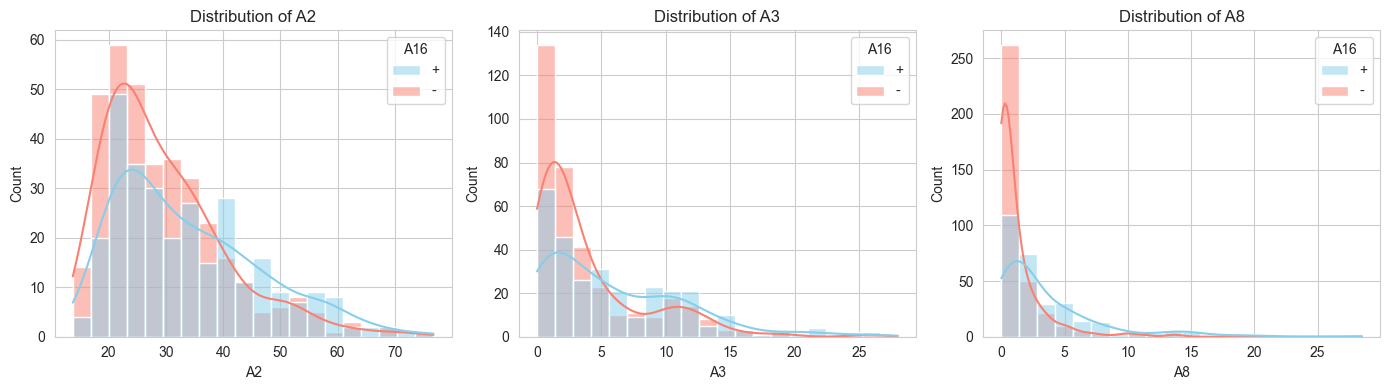

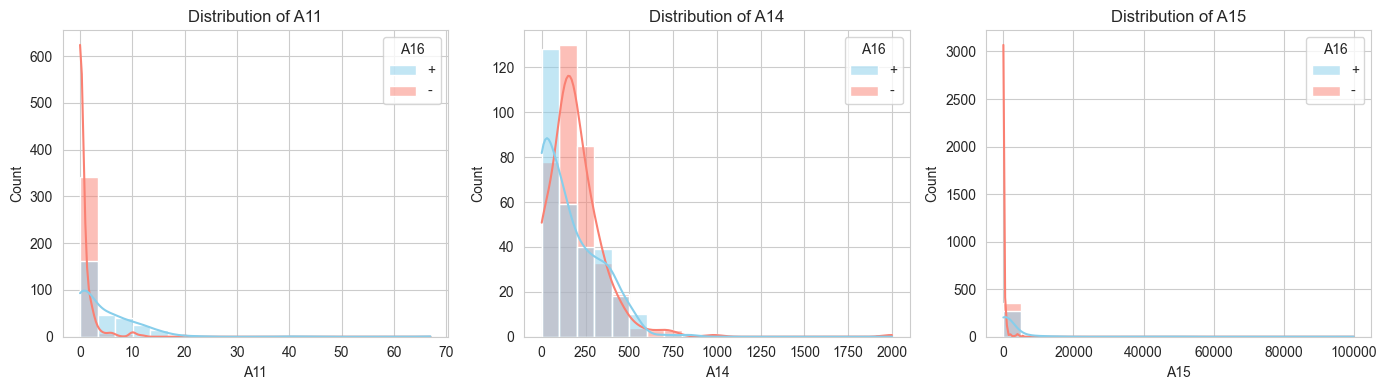

In [71]:
# get continuous features
continuous_cols = df.select_dtypes(include = 'float64').columns.to_list()

# plot continuous feature distribution
plot_numerical_distributions(df, columns = continuous_cols)

The distributions indicates that continuous features are highly skew to the left. Especially for A8, A11 and A15, when data tend to reach to zero, it is likely that the credit card application is rejected.

#### Step 2.4.3. Boxplot for extreme values

In [72]:
def plot_boxplots(df, columns):
    for i in range(0, len(columns), 3):
        batch = columns[i:i+3]
        fig, axes = plt.subplots(1, len(batch), figsize=(14, 5))
        
        if len(batch) == 1:
            axes = [axes]  # Convert to list if only one axis
            
        for j, col in enumerate(batch):
            # Calculate quartiles and IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            # Calculate thresholds
            lower_extreme = np.maximum(Q1 - 3 * IQR,0) 
            upper_extreme = Q3 + 3 * IQR
            sns.boxplot(data=df, y=col, ax=axes[j], width=0.5)
            axes[j].set_title(f'Boxplot of {col}')

            # Add horizontal lines for extreme thresholds
            axes[j].axhline(y=lower_extreme, color='red', linestyle='--', linewidth=2, 
            label=f'Q1 - 3×IQR = {lower_extreme:.2f}')
            axes[j].axhline(y=upper_extreme, color='red', linestyle='--', linewidth=2,
            label=f'Q3 + 3×IQR = {upper_extreme:.2f}')
        
        #plt.tight_layout()
        plt.show()

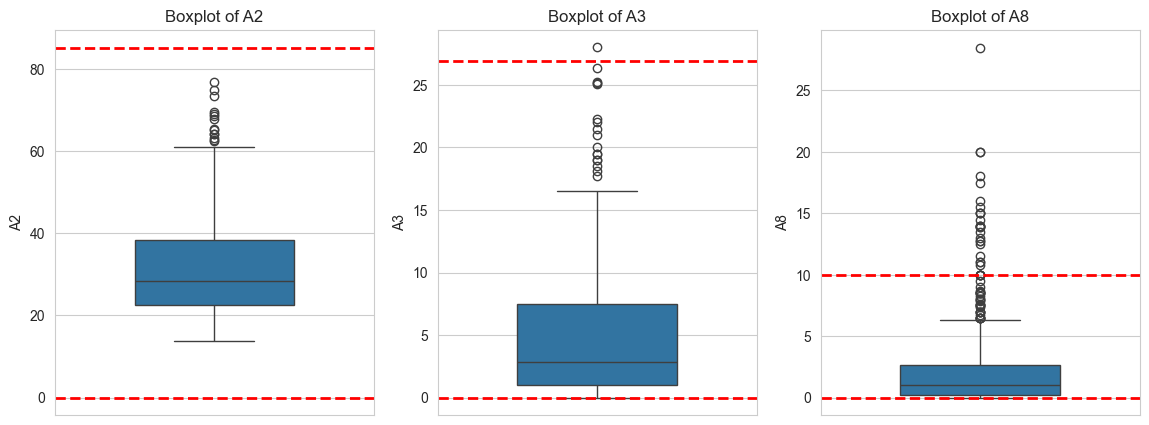

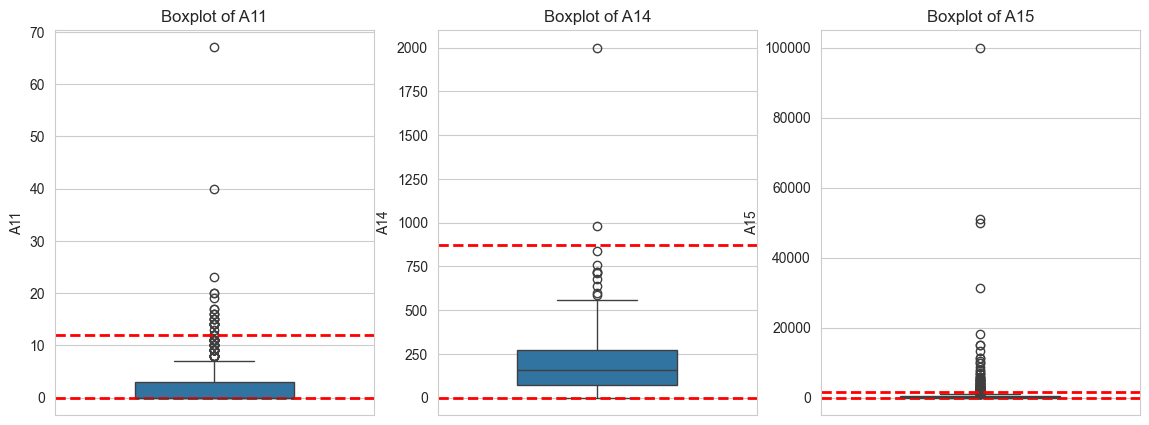

In [73]:
plot_boxplots(df,columns = continuous_cols)

The boxplots reveal numerous extreme values in features A8, A11, and A15. While these values may warrant removal as outliers before modeling, we cannot definitively determine whether they represent true outliers or inherent data characteristics. Therefore, we will retain them for subsequent analysis steps.

While random forests are generally robust against outliers, logistic regression and KNN models are sensitive to outliers as they use the magnitude of and distance between data points.

### Step 2.4. Target Variable Distribution
I will now take a look at the distribution of the target variable, `A16`, to determine if there is a class imbalance.

Text(0.5, 1.0, 'Boxplot of target variable A16')

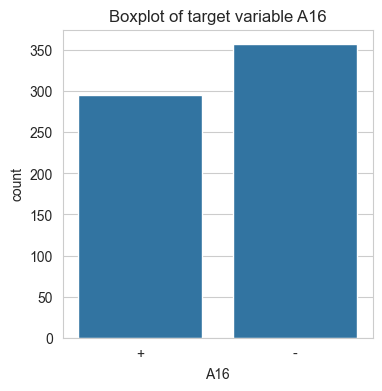

In [74]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.countplot(data=df, x='A16')
ax.set_title(f'Boxplot of target variable A16')

In [75]:
# Get percentages
# Create a summary DataFrame
summary = pd.DataFrame({
    'Count': df['A16'].value_counts(),
    'Percentage': df['A16'].value_counts(normalize=True) * 100
})
print(summary)

     Count  Percentage
A16                   
-      357    54.67075
+      296    45.32925


Of all applications, 55% were declined and 45% were accepted. The dataset is quite balanced between classes.

The class labels aren't significantly imbalanced, but there is an imbalance nevertheless, with 36% of credit card applications being accepted and 64% being declined. I will keep this in mind going forward, particularly while evaluating model performance as class imbalance can hinder a model's ability to learn and predict the minority class label. 

## Step 3: Correlation Analysis
Random forest models are not particularly sensitive to multicollinearity in the way that linear models like logistic regression are because their split points are not based on linear coefficients. However, it is still worth exploring whether there are redundant features as this can reduce feature importance and interpretability. For this, I will explore the correlations between continuous input features by building a correlation matrix using `panda`'s `.corr()` function and identifying cases where the Pearson correlation coefficient indicates a strong correlation ($|r|>0.8$). I will perform this correlation analysis before one-hot encoding the categorical features because this can create artifial feature correlations that shouldn't be removed.

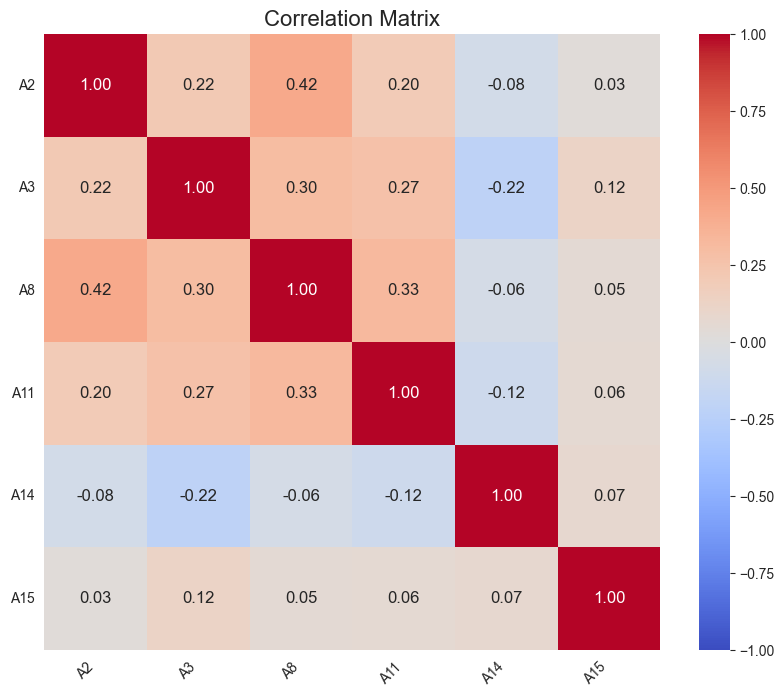

Pairs of correlated features: []


In [76]:
# compute correlation matrix
corr_matrix = df.select_dtypes(include=['float64']).corr()

# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,annot=True,fmt=".2f",annot_kws={"size": 12},cmap="coolwarm",vmin=-1,vmax=1,square=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

corr_feature_pairs = []
# iterate through indices of upper-right triangle
# of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i+1,len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        # correlated pairs if |r|>0.8
        if abs(r) > 0.8:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_feature_pairs.append((col1,col2,r))

print("Pairs of correlated features:", corr_feature_pairs)

This reveals that there are no strongly correlated continuous features that need to be removed.

## Step 4. Train Test Split and Feature Scaling
Before proceeding with feature engineering, I'll follow the standard process of separating the input features (`X`) from the target variable (`y`) and splitting the data into training (`_train`) and testing (`_test`) sets using `scikit-learn`'s `train_test_split()` function. Splitting the data into training and testing sets allows us to evaluate the model performance using an independent dataset that the model hasn't seen during its training phase. This is an essential step for determining how well an ML model generalizes to unseen data.

Since the class labels are `+` and `-`, I'm going to map them to `1` and `0` as this is the default behaviour of what `scikit-learn` expects. Otherwise this can affect metrics such as ROC-AUC.

In [77]:
# define features
X = df.drop(columns='A16')

# define target variable
y = df['A16'].map({'+': 1, '-': 0})

Recall that there is a slight imbalance in the target variable. Therefore, while creating the training and testing sets, I will use `train_test_split`'s `stratify` argument to ensure that the relative proportions of each class (negative and positive) are the same in all subsets as the original dataset. The `train_test_split()` function randomly splits the data into training and testing sets, so not using `stratify` could result in unequal class label in the training and testing data data, which could make it more challenging for the model to learn the two classes equally well.

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

## Step 5: Feature Engineering
My exploratory analysis revealed the following areas where feature engineering will be needed to prepare the data for modelling:

- categorical features need to be encoded to numerical form
- continuous features need to be scaled to a consistent distribution central tendency and width

### Step 5.1. Feature Encoding

I'll start by encoding the categorical features so they can be used by the model. Since the data is anonymized, I don't know if the categorical features are ordinal (having a natural order) or nominal (not having a natural order). I don't think we can assume that the features are nominal, and doing so can significantly affect how the model interprets these features, particularly with the logistic regression and KNN models.

I'll take the safer bet and assume that these features are nominal, for which I'll one-hot encoding. I'll do this using `panda`'s `pd.get_dummies()`, which converts the categorical features into binary features, and use `drop_first=True` to drop the redundant binary column to reduce multicolinearity. I'll generate the dummy variables separately so I can easily convert them from boolean type (True or False) to integer values (1 or 0).

To ensure that there is no data leakage between the training and testing datasets, I will make sure that only the categories in the training data appear in the testing data. If new features do happen to appear in the testing dataset, I will assign these value of zero (i.e., not present).

I'll start by defining the continuous features, categorical features, and target variable.

In [79]:
# continuous features
continuous_features = df.select_dtypes(include=['float64']).columns

# categorical features
categorical_features = df.drop(columns=['A16']).select_dtypes(include=['object']).columns

# target variable
target_variable = ['A16']

Now I will encode the training dataset.

In [80]:
# train encoder on categorical features in training dataset only
X_train_dummies = pd.get_dummies(X_train[categorical_features],drop_first=True).astype(int)

# drop original categorical features from training data as they're now redundant
X_train_continuous = X_train.drop(columns=categorical_features)

# concatenate original dataframe with that containing the dummy variables
X_train_encoded = pd.concat([X_train_continuous,X_train_dummies], axis=1)

# update training dataset
X_train = X_train_encoded

Next I will encode the testing dataset. This follows the same steps as encoding the training data, except the last line ensures that the encoded testing dataset has the exact same features as the encoded training dataset.

In [81]:
# train encoder on categorical features in testing dataset only
X_test_dummies = pd.get_dummies(X_test[categorical_features],drop_first=True).astype(int)

# drop original categorical features from testing data as they're now redundant
X_test_continuous = X_test.drop(columns=categorical_features)

# concatenate original dataframe with that containing the dummy variables
X_test_encoded = pd.concat([X_test_continuous,X_test_dummies],axis=1)

# ensure features in testing dataset match those in training dataset
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns,fill_value=0)

# update testing dataset
X_test = X_test_encoded

### Step 5.2. Feature Scaling

I'll now map the continuous features using `scikit-learn`'s `StandardScaler` to ensure that their mean is zero and standard deviation is one. To again ensure that there is no data leakage between the training and testing datasets, I will train the scaler on the training data only and then apply the scaler to both the training and testing datsets.

In [82]:
# train the scaler on the training dataset only
scaler = StandardScaler()
scaler.fit(X_train[continuous_features])

# transform the training dataset
X_train[continuous_features] = scaler.transform(X_train[continuous_features])

# transform the testing dataset
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

In [83]:
# review the training dataset
X_train.head()

,A2,A3,A8,A11,A14,A15,A1_b,A4_u,A4_y,A5_gg,...,A7_j,A7_n,A7_o,A7_v,A7_z,A9_t,A10_t,A12_t,A13_p,A13_s
239,0.554537,1.062976,0.098497,0.672461,2.023721,-0.149863,1,1,0,0,...,0,0,0,1,0,1,1,0,0,0
434,2.246098,-0.431190,0.072554,-0.502845,0.833659,-0.183938,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0
344,0.616696,-0.624635,-0.511919,-0.502845,0.714653,-0.183590,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0
425,-0.571789,-0.725388,-0.588221,-0.502845,-0.415906,-0.183938,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
552,0.271091,2.045317,0.975970,1.260114,-1.070440,-0.160641,1,1,0,0,...,0,1,0,0,0,1,1,1,0,0


In [84]:
# review the testing dataset
X_test.head()

,A2,A3,A8,A11,A14,A15,A1_b,A4_u,A4_y,A5_gg,...,A7_j,A7_n,A7_o,A7_v,A7_z,A9_t,A10_t,A12_t,A13_p,A13_s
540,-0.999445,-0.675012,-0.054107,-0.502845,-0.475409,-0.180461,1,0,1,0,...,0,0,0,1,0,1,0,1,0,0
256,-0.951375,1.248362,-0.054107,-0.502845,-0.261198,-0.183938,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
687,-0.516260,1.743058,-0.054107,-0.306960,0.119622,-0.183764,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
263,-0.916566,1.138541,-0.664523,-0.502845,-0.154092,-0.178374,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
487,-0.578419,1.709810,-0.652315,-0.502845,-0.356403,-0.101357,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0


## Step 6: Logistic Regression Model
The first model that I will train is a logistic regression model.

### Step 6.1. Train the Model
I will train the logistic regression model using `scikit-learn`'s `LogisticRegression()` function.

In [85]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)

LogisticRegression()

### Step 6.2. Model Performance

I will now test the model performance to get a better understanding of how well the logistic regression model performs on unseen data.

#### Step 6.2.1. Confusion Matrix

The confusion matrix is a diagnostic tool used to evaluate the performance of a classification model by summarizing how the predicted class labels compare to the actual class labels. For binary classification, the confusion matrix is a 2x2 matrix where the elements along the diagonal represent the true negative (TN) and true positive (TP) class labels (i.e., correct labels), while the off-diagonal elements represent the false negative (FN) and false positive (FP) class labels (i.e., incorrect labels). This simple structure demonstrates whether the model is able to properly separate positive and negative class labels, and whether there is any confusion between them.

It is worth noting that different sources use different conventions for the confusion matrix; `scikit-learn` uses the following convention: "...the count of true negatives is [0,0], false negatives is [1,0], true positives is [1,1] and false positives is [0,1]." Knowing this allows us to calculate two additional metrics that aren't included in the classification report (next step): the false positive rate (FPR) and false negative rate (FNR).

[[61 11]
 [ 4 55]]


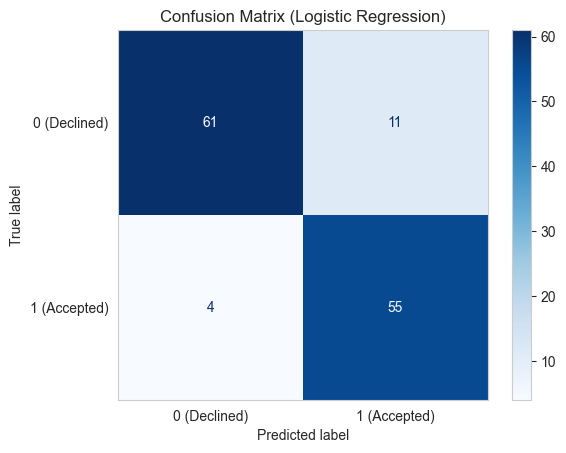

In [86]:
# make prediction on the test set
y_pred_log = logistic.predict(X_test)

# calculate confusion matrix
cm_log = confusion_matrix(y_test,y_pred_log)
print(cm_log)

# plot confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['0 (Declined)', '1 (Accepted)'])
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()


The confusion matrix for this logistic model demonstrates that the majority of predictions are correct with 84% of test samples being either TN or TP and only 16% of predictions being either Type I (FP) or Type II (FN) errors. While we can calculate metrics like precision and recall from the confusion matrix, the classification report in the following section provides these metrics to us.

#### Step 6.3.2. Classification Report
The classification report is another common diagnostic tool used to evaluate the performance of a classification model, which summarizes four key metrics: precision, recall, f1-score, and support.

Precision quantifies how well you can trust a positive prediction, measured as the proportion of positive predictions that were correct:

$$
\begin{aligned}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{aligned}
$$

The recall is complementary to precision, which quantifies the coverage of true positives measured as the proportion of true positives that were identified:

$$
\begin{aligned}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{aligned}
$$

The F1-score is the harmonic mean of precision and recall, which offers a more balanced metric and can be particularly useful when there is a class imbalance:

$$
\begin{aligned}
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
\end{aligned}
$$

Lastly, support is the total number of occurrences in each class label and can help to provide context for the above key metrics, particularly in the case of a class imbalance.

In [87]:
# compute classification report
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        72
           1       0.83      0.93      0.88        59

    accuracy                           0.89       131
   macro avg       0.89      0.89      0.89       131
weighted avg       0.89      0.89      0.89       131



The classification report demonstrates the strong performance for logistic regression model, with an accuracy of 89% and precision, recall and f1-score at 89% too.

#### Step 6.3.3. ROC-AUC Score
The ROC (Receiver Operating Characteristic) curve is a diagnostic tool that visualizes the trade-off between the True Positive Rate (TPR, also known as sensitivity or recall) and the False Positive Rate (FPR) at various classification thresholds. A perfect classifier would have a curve that hugs the top-left corner of the plot, while a model that performs no better than random chance would follow the diagonal line. The AUC (Area Under the Curve) quantifies the overall ability of the model to distinguish between classes. In the case of a perfect classifier, the AUC would be 1.0 since the ROC curve hugs the top-left cornere of the plot. In contrast, a classifier that is unable to discriminate between classes would have an AUC closer to 0.5 since the ROC curve would follow the diagonal.

In [88]:
# get predicted probabilities for positive class
y_prob_log = logistic.predict_proba(X_test)[:,1] # extract positive class

# compute ROC curve
fpr_log, tpr_log, thresholds_log = roc_curve(y_test,y_prob_log)

# compute AUC score
auc_score_log = roc_auc_score(y_test,y_prob_log)

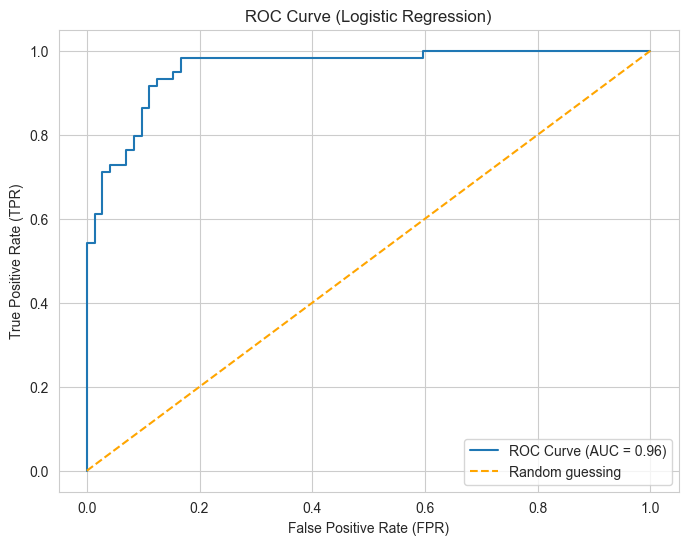

In [89]:
# plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_log,tpr_log,label=f"ROC Curve (AUC = {auc_score_log:.2f})") # ROC curve with AUC score
plt.plot([0,1],[0,1],color="orange",linestyle="dashed",label="Random guessing") # 1:1 line for random guessing
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.show()

The ROC curve is significantly close to the top-left corner of the plot and has an AUC score of 0.96, both of which indicate that this model performs relatively well with differentiating between positive and negative class labels. The result table below summarize the model performance


In [114]:
Results = pd.DataFrame({'AUC':'0.96', 'Precision':'0.89','Recall':'0.89','F1-Score':'0.89','accuracy':'0.89'},index=['Logistic'])
Results


,AUC,Precision,Recall,F1-Score,accuracy
Logistic,0.96,0.89,0.89,0.89,0.89


## Step 7: Random Forest Model

### Step 7.1. Hyperparameter Tuning
I will train a random forest model using `scikit-learn`'s `RandomForestClassifier()` function, starting with hyperparameter tuning. Since I know that there is a pretty balance, I will use the `class_weight='balanced'` argument in `RandomForestClassifier()` to adjust the weights of each class to ensure that they contribute equally to the training phase. `RandomizedSearchCV()` is used instead of `GridSearchCV()` for hyperparameter tuning over a larger parameter space. I will randomly search 100 samples of the parameter search grid using `n_iter=100`, use 5 equal folds in our cross-validation using `cv=5`, and optimize ROC-AUC using `scoring='roc_auc'`. 

The `RandomizedSearchCV()` function implicitly assumes k-fold cross validation, which randomly splits the data into k folds and could result in some folds having less samples from the minority class label. To ensure that all k folds have a representative proportion of class labels, I will use the `StratifiedKFold()` function for cross-validation.

In [91]:
# define stratified k-fold cross validator
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [10, 20, 50, 100],
    'class_weight': ['balanced']
}

# build the random forest model
rf = RandomForestClassifier(random_state=42)

# randomized search optimizing ROC-AUC
search_rf = RandomizedSearchCV(estimator=rf,param_distributions=param_grid,n_iter=100,cv=cv,scoring='roc_auc',random_state=42,n_jobs=1,verbose=1)

# fit the model
search_rf.fit(X_train,y_train)

# extract the model with the best recall
rf_tuned = search_rf.best_estimator_

# make predictions on the test set
y_pred_rf_tuned = rf_tuned.predict(X_test)

# print best-fit model parameters
print(f"best-fit model parameters (ROC-AUC={search_rf.best_score_:.2f}): {search_rf.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best-fit model parameters (ROC-AUC=0.93): {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 10, 'class_weight': 'balanced'}


This yielded a random forest model with an optimal ROC-AUC of 0.93.

### Step 7.2. Model Performance

#### Step 7.2.1. Confusion Matrix

[[63  9]
 [ 8 51]]


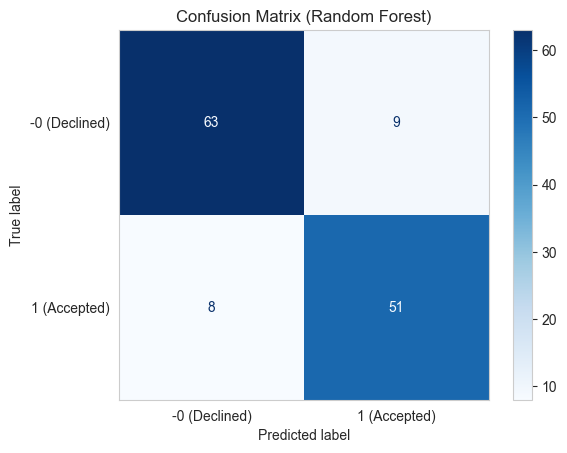

In [92]:
# calculate confusion matrix
cm_rf = confusion_matrix(y_test,y_pred_rf_tuned)
print(cm_rf)

# plot confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['-0 (Declined)', '1 (Accepted)'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Random Forest)')
plt.grid(False)
plt.show()


#### Step 7.2.2. Classification Report

In [93]:
# compute classification report
print(classification_report(y_test,y_pred_rf_tuned))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88        72
           1       0.85      0.86      0.86        59

    accuracy                           0.87       131
   macro avg       0.87      0.87      0.87       131
weighted avg       0.87      0.87      0.87       131



The random forest model achieved accuracy, precision, recall and f1-score at 87%.

#### Step 7.2.3. ROC-AUC Score

In [94]:
# get predicted probabilities for positive class
y_prob_rf = rf_tuned.predict_proba(X_test)[:,1] # extract positive class

# compute ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test,y_prob_rf)

# compute AUC score
auc_score_rf = roc_auc_score(y_test,y_prob_rf)

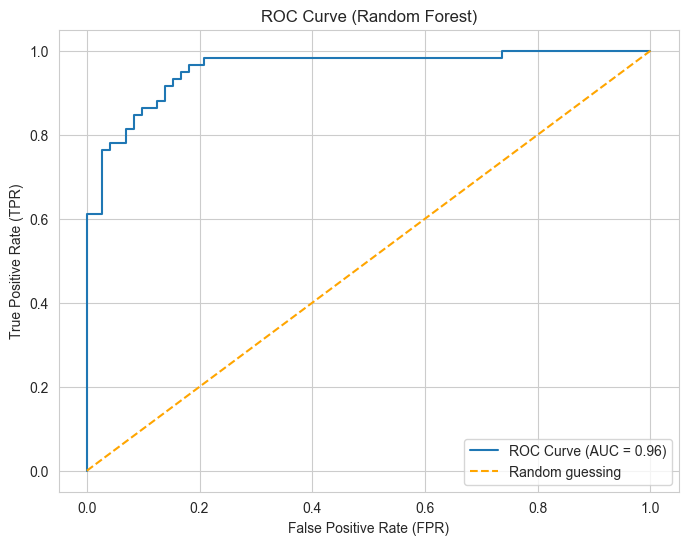

In [95]:
# plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_rf,tpr_rf,label=f"ROC Curve (AUC = {auc_score_rf:.2f})") # ROC curve with AUC score
plt.plot([0,1],[0,1],color="orange",linestyle="dashed",label="Random guessing") # 1:1 line for random guessing
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()

The ROC curve is relatively close to the top-left corner of the plot, with an AUC score of 96%, indicating that the random forest model performs well with differentiating between positive and negative classes. 

In [115]:
Results.loc['Random Forest'] = {'AUC': '0.96', 'Precision': '0.87', 'Recall': '0.87', 'F1-Score': '0.87','accuracy':'0.87'}
Results

,AUC,Precision,Recall,F1-Score,accuracy
Logistic,0.96,0.89,0.89,0.89,0.89
Random Forest,0.96,0.87,0.87,0.87,0.87


## Step 8: Multi-layer Perceptron (neural network) classifier 
`MLPClassifier` is a Multi-layer Perceptron (neural network) classifier from scikit-learn that implements feedforward artificial neural networks for classification tasks. It's part of sklearn.neural_network and uses backpropagation for training. Despite being a neural network, it's designed to follow sklearn's standard API, making it easy to use with other sklearn tools.

### Key Parameters
Architecture:  
`hidden_layer_sizes`: Tuple defining the number of neurons in each hidden layer. For example, (100, 50) creates 2 hidden layers with 100 and 50 neurons
Default is (100,) - a single hidden layer with 100 neurons

`Activation Functions`: Options include 'relu' (default), 'logistic', 'tanh', 'identity'

`Solver` (Optimization): 'adam' (default, good for large datasets), 'lbfgs' (good for small datasets), 'sgd' (stochastic gradient descent)


### 8.1 Model Tuning

In [109]:
# Calculate hidden layer size

param_grid = {
    'hidden_layer_sizes': [(20,),(15,),(12,),(10,)],
    'activation': ['relu'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['adaptive'],
    'max_iter': [300,500]
}
mlp = MLPClassifier(random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # or 'f1', 'roc_auc', etc.
    n_jobs=1,  # use all available cores
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Use the best model to make predictions
best_mlp = grid_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, max_iter=300; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, max_iter=300; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, max_iter=300; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, max_iter=300; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, max_iter=300; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, max_iter=500; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, max_iter=500; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_ra

### 8.2 Model Performance

#### 8.2.1 Confusion Matrix

[[63  9]
 [ 8 51]]


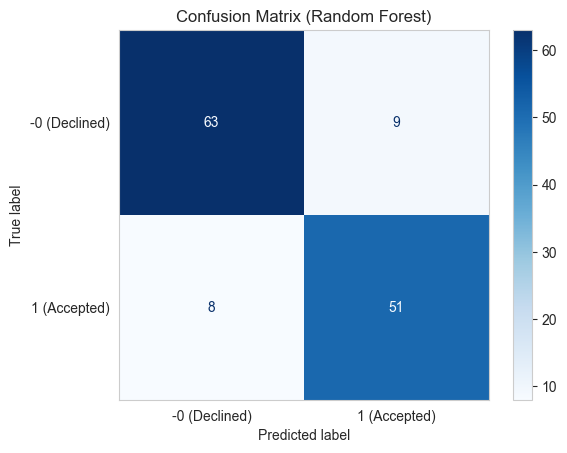

In [110]:
# calculate confusion matrix
cm_nn = confusion_matrix(y_test,y_pred_mlp)
print(cm_rf)

# plot confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['-0 (Declined)', '1 (Accepted)'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Random Forest)')
plt.grid(False)
plt.show()

#### 8.2.2 Classification Report

In [111]:
# compute classification report
print(classification_report(y_test,y_pred_mlp))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        72
           1       0.86      0.86      0.86        59

    accuracy                           0.88       131
   macro avg       0.88      0.88      0.88       131
weighted avg       0.88      0.88      0.88       131



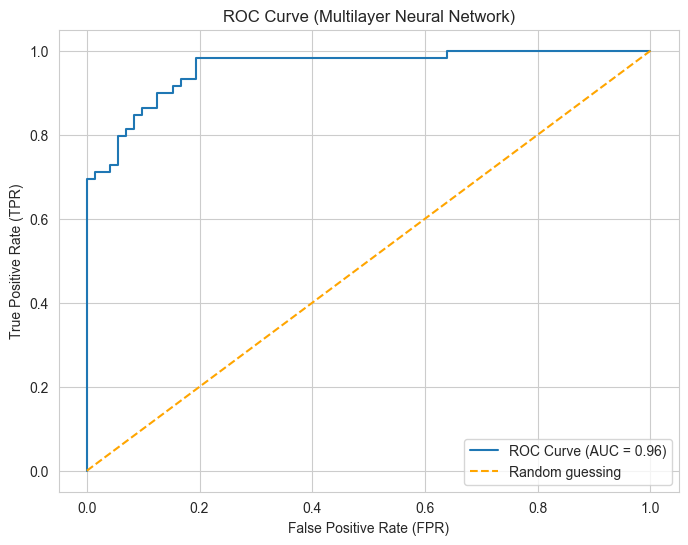

In [112]:
# get predicted probabilities for positive class
y_prob_mlp = best_mlp.predict_proba(X_test)[:,1] # extract positive class

# compute ROC curve
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test,y_prob_mlp)

# compute AUC score
auc_score_mlp = roc_auc_score(y_test,y_prob_mlp)

# plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_mlp,tpr_mlp,label=f"ROC Curve (AUC = {auc_score_mlp:.2f})") # ROC curve with AUC score
plt.plot([0,1],[0,1],color="orange",linestyle="dashed",label="Random guessing") # 1:1 line for random guessing
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (Multilayer Neural Network)")
plt.legend()
plt.show()

In [116]:
Results.loc['MLP'] = {'AUC': '0.95', 'Precision': '0.88', 'Recall': '0.88', 'F1-Score': '0.88','accuracy':'0.88'}
Results.index.name = 'Models'
Results

,AUC,Precision,Recall,F1-Score,accuracy
Models,,,,,
Logistic,0.96,0.89,0.89,0.89,0.89
Random Forest,0.96,0.87,0.87,0.87,0.87
MLP,0.95,0.88,0.88,0.88,0.88


## Step 9. Summary and Next Steps
This demonstrates the process of building a model that predicts whether credit card applications should be approved or denied using logistic regression, random forest models and Multi-layer Perceptron (neural network) classifier based on anonymized data. There were a total of 690 data samples with 6 continuous features, 9 categorical features, and one class label. The target variable was a binary categorical variable, including a negative class label `-` representing declined applications and a positive class label `+` represing accepted applications. These class labels were mapped to integer values `0` and `1`, respectively, to avoid any class ambiguity with `scikit-learn`.

An EDA revealed that data is pretty balanced, with the ratio between positive label to negative label is 45:55. Data samples with missing entries were dropped as they accounted for less than 2% of the entire dataset. A correlation analysis was performed to identify features that are strongly correlated to reduce multicollinearity. However, no feature pairs were found to be strongly correlated. 

After the data was split into a training and testing set, the categorical features were encoded and the continuous features were scaled. To ensure that there was no data leakage to the testing data, only categorical features that appeared in the training data were included in the testing data. Furthermore, the standard scaler was trained only on the training data, after which it was applied to the testing data. Three classification models were built and compared: (1) logistic regression, (2) random forest, and (3) Multi-layer Perceptron (neural network) classifier. 

Overall, the logistic regression model was found to have the strongest performance with AUC, Precision, Recall and F1-score at 0.96, 0.89, 0.89 respectively. This was followed by Multi-layer Perceptron, which achieved a 88% for all three metrics Precision, Recall and F1-score. Even thought its AUC metric is slightly behind Random Forest model. 

Next steps could involve a feature importance analysis (e.g., SHAP values) to understand which features drive the most impact on credit card application decisions in addition to experimenting with more advanced ensemble models, such as XGBoost. Furthermore, we can adjust probability threshold to see how it impact to accuracy, precision and recall.
